In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from utils import train_with_reg_cv, train_with_chain, train_with_chain_simp,train_with_reg_chain, sst_binary

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

In [2]:
train_df = pd.read_csv('train.tsv',sep='\t',header = 0)
test_df = pd.read_csv('test.tsv',sep='\t',header=0)
sub = pd.read_csv('sampleSubmission.csv',sep=',',header=0)
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
## Get train X and Y
train_X = train_df['Phrase'].tolist()
test_X = test_df['Phrase'].tolist()
train_y = train_df['Sentiment']

In [4]:
trX, trY = sst_binary()

In [6]:
sentiment_unit = trXt[:, 2388]
plt.hist(trY[trY==0],bins=25,alpha=0.5, label='neg')
plt.hist(trY[trY==1],bins=25,alpha=0.5, label='some neg')
plt.hist(trY[trY==2], bins=25,alpha=0.4,label='neut')
plt.hist(trY[trY==3],bins=25,alpha=0.5, label='some pos')
plt.hist(trY[trY==4],bins=25,alpha=0.5,label='pos')
plt.legend()
plt.show()

NameError: name 'trXt' is not defined

In [ ]:
## Using OpenAI sentiment generation feature extracter on train_X
from encoder import Model
model = Model()
trXt = model.transform(trX)
teXt= model.transform(test_X)


488.026 seconds to transform 66292 examples


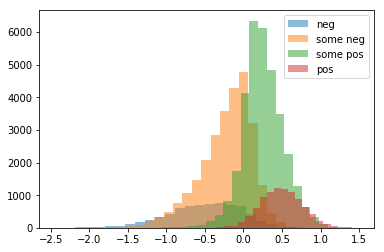

In [15]:
from matplotlib import pyplot as plt

sentiment_unit = trXt[:, 2388]
plt.hist(sentiment_unit[trY==0],bins=25,alpha=0.5, label='neg')
plt.hist(sentiment_unit[trY==1],bins=25,alpha=0.5, label='some neg')
#plt.hist(sentiment_unit[trY==2], bins=25,alpha=0.4,label='neut')
plt.hist(sentiment_unit[trY==3],bins=25,alpha=0.5, label='some pos')
plt.hist(sentiment_unit[trY==4],bins=25,alpha=0.5,label='pos')
plt.legend()
plt.show()

In [5]:
len(fullX)

20000

In [21]:
labels = list(train_y[:20000])
labels[:10]

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [6]:
split_frac = 0.8
split_ids = int(len(trXt)*split_frac)

train_x, val_x = trXt[:split_ids],trXt[split_ids:]
train_y, val_y = trY[:split_ids],trY[split_ids:]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape))

			Feature Shapes:
Train set: 		(124848, 4096) 
Validation set: 	(31212, 4096)


In [7]:
##One-hot encode train labels
from keras.utils import np_utils
train_y = np_utils.to_categorical(np.array(train_y),5)

Using TensorFlow backend.


In [8]:
train_y.shape

(124848, 5)

In [9]:
##One-hot encode val labels
val_y = np_utils.to_categorical(np.array(val_y),5)
val_y.shape

(31212, 5)

In [14]:
# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import function for training acoustic model
from utils import train_with_reg_cv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
## Clssify model using OpenAI extracted features
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation,Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adagrad, Adadelta, SGD, Adam


model_openai = Sequential()
model_openai.add(Dense(1024, input_shape = (4096,)))
model_openai.add(Activation('relu'))
model_openai.add(BatchNormalization())
model_openai.add(Dropout(0.5))
model_openai.add(Dense(512))
model_openai.add(Activation('relu'))
model_openai.add(BatchNormalization())
model_openai.add(Dropout(0.5))
model_openai.add(Dense(256))
model_openai.add(Activation('relu'))
model_openai.add(BatchNormalization())
model_openai.add(Dropout(0.4))
model_openai.add(Dense(128))
model_openai.add(Activation('relu'))
model_openai.add(BatchNormalization())
model_openai.add(Dropout(0.4))
model_openai.add(Dense(5))
model_openai.add(Activation('softmax'))

optimizer = Adagrad(lr=0.001)

model_openai.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['acc'])
print(model_openai.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
__________

In [2]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint('weights.best.RNN_LSTM_OPENAI.hdf5',verbose=1,save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',mode = 'min', patience = 4)

epochs = 50
model_openai.fit(train_x,train_y,epochs = epochs,validation_data=(val_x,val_y),callbacks=[check_point,early_stop],verbose=1,batch_size=64)


NameError: name 'train_x' is not defined

In [ ]:
## Multinomial logistic regression to classify the sentiments into 5 classes. Model implemented in utils.py.

full_rep_acc,c,nnotzero,predictions = train_with_reg_cv(train_x,train_y,val_x,val_y,test_features)
print('%05.2f test accuracy'%full_rep_acc)
print('%05.2f reg coefficeint'%c)
print('%05d features used'%nnotzero)

In [14]:
## Chain classification to classify the sentiments into 5 classes. Model implemented in utils.py.

full_rep_acc,predictions = train_with_reg_chain(train_x,train_y,val_x,val_y,test_features)
print('%05.2f test accuracy'%full_rep_acc)
#print('%05.2f reg coefficeint'%c)
#print('%05d features used'%nnotzero)

NameError: name 'RegressorChain' is not defined

In [83]:
predictions[:10]

array([[ 0. ,  0.2,  0.5,  0.3,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0.4,  0.6,  0. ,  0. ],
       [ 0. ,  0.3,  0.2,  0.4,  0.1],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ]])

In [85]:
import operator

c_predictions = []
for i in range(len(predictions)):
    index, value = max(enumerate(predictions[i]), key=operator.itemgetter(1))
    c_predictions.append(index)

len(c_predictions)

66292

In [86]:
c_predictions[:10]

[2, 2, 2, 2, 2, 2, 3, 2, 3, 2]

In [84]:
## Using OpenAI extracted features with CNN layer to classify text
from keras import backend as K
from keras.models import Model
from keras.layers import Conv1D, Dense, Flatten,BatchNormalization, Input, MaxPooling1D, Dropout
from keras.optimizers import RMSprop

input_data = Input(shape = (4096,1),name='input_data')
cnn_1 = Conv1D(filters=128,kernel_size=2,activation='relu',name='cnn_1')(input_data)
#bn_cnn1 = BatchNormalization()(cnn_1)
max_1 = MaxPooling1D(5)(cnn_1)
cnn_2 = Conv1D(filters = 128, kernel_size=2,activation='relu',name='cnn_2')(max_1)
#bn_cnn2=BatchNormalization()(cnn_2)
max_2 = MaxPooling1D(5)(cnn_2)
flat = Flatten()(max_2)
dense_1 = Dense(64,activation='relu')(flat)
drop = Dropout(0.5)(dense_1)
preds = Dense(5,activation='softmax')(drop)

optimizer = RMSprop (lr=0.001, epsilon = 1e-08, rho=0.9,decay=0.0)

model = Model(inputs=input_data,outputs=preds)
model.compile(loss='categorical_crossentropy',optimizer = optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      (None, 4096, 1)           0         
_________________________________________________________________
cnn_1 (Conv1D)               (None, 4095, 128)         384       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 819, 128)          0         
_________________________________________________________________
cnn_2 (Conv1D)               (None, 818, 128)          32896     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 163, 128)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 20864)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                1335360   
__________

In [85]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
check_point = ModelCheckpoint('weights.best.CNN_OPENAI.hdf5',verbose=1,save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',mode = 'min', patience = 3)

epochs = 10
model.fit(train_x,train_y,validation_data=(val_x,val_y),callbacks=[check_point,early_stop],verbose=1,epochs=epochs,batch_size=25)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 149s - loss: 1.0108 - acc: 0.5955 - val_loss: 0.9689 - val_acc: 0.6005
Epoch 2/10
124848/124848 [==============================] - 149s - loss: 0.9893 - acc: 0.6013 - val_loss: 0.9975 - val_acc: 0.5928
Epoch 3/10
124848/124848 [==============================] - 149s - loss: 0.9911 - acc: 0.5999 - val_loss: 0.9801 - val_acc: 0.5956
Epoch 4/10
124848/124848 [==============================] - 149s - loss: 0.9942 - acc: 0.5972 - val_loss: 0.9997 - val_acc: 0.5849
Epoch 5/10
124848/124848 [==============================] - 149s - loss: 0.9986 - acc: 0.5958 - val_loss: 0.9947 - val_acc: 0.5877


In [17]:
##load weights
model_openai.load_weights('weights.best.RNN_LSTM_OPENAI.hdf5')

LSTM_predictions = []
for i in range(len(teXt)):
    prediction = np.argmax(model_openai.predict(teXt[i].reshape(1,teXt.shape[1]),verbose=0)[0])
    LSTM_predictions.append(prediction)

In [52]:
LSTM_predictions[:10]

[1, 1, 2, 1, 1, 2, 3, 2, 3, 2]

In [18]:
LSTM_1 = LSTM_predictions##

In [43]:
LSTM_2 = LSTM_predictions #

In [49]:
LSTM_3 = LSTM_predictions#####

In [53]:
LSTM_4 = LSTM_predictions ####

In [61]:
LSTM_5 = LSTM_predictions

In [65]:
LSTM_6 = LSTM_predictions ###

In [68]:
LSTM_7 = LSTM_predictions ##

In [19]:
sub['Sentiment'] = LSTM_1
sub.to_csv('oailstm_4.csv',index=False)